In [1]:
import os
import math
import time
import warnings
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import simpson
from joblib import Parallel, delayed
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,auc,roc_curve,roc_auc_score,log_loss
from sklearn.model_selection import train_test_split,cross_val_score, KFold


warnings.filterwarnings("ignore")
randomstate=1 # Random State for all logistic regression fitting

# Sensitivity Maximization At Given Specificity (SMAGS)

All the graphs in the paper were plotted by setting the random state in logistic regression equal to 1. For any other random state, you might have slightly different graphs.

In [2]:
''' 
Sensitivity Maximization At Given Specificity (SMAGS):

Choosing features that have the highest sensitivity for pre-specified specificity

input:

X: Features: It must be in the format of Pandas dataframe
y: Labels: It must be in a format of Pandas Series of classes (class column) with numerical values (0 and 1)
SP: The threshold value for specificity (Default is 0.985)
lower_bound: Specifying if we want to set a boundary for the coefficients of the feature or not.
        The dimesnion of the bounds must be X.shape[1] + 1 (the plus one is for intercept)
        
  
output:

A series with the following values:

Coefficients of the logistic regression that gives us the highest sensitivity (including the intercept)
Plus, the threshold, specificity, sensitivity, optimization method, tolerance, jacobian approach and AIC.


'''
def SMAGS(X,y,SP=0.985,lower_bound=None,rand=randomstate):
    n_features=X.shape[1]
    log = LogisticRegression(random_state=rand).fit(X,y)
    all_coefs=np.append(log.coef_[0],log.intercept_)
    X1=X.assign(I = 1)
    
    def sig(M):
        return  1/(1 + np.exp(-(M)))

    def custom_loss(coefs):
        m=np.matmul(X1,coefs )
        z = sig(m.astype(float))
        if len(((1-y)*z)[(1-y)*z!=0])!=0:
            threshold=np.quantile(((1-y)*z)[(1-y)*z!=0],SP)
        else:
            threshold=0
        y_hat = 1*(z > threshold)
        loss1 = np.dot(y_hat,y)/sum(y)
        return -loss1
    
    bnds = ([(lower_bound, None) for i in range(n_features)])
    bnds.append((None,None)) # Intercept Bound
      
    opt_methods=['Nelder-Mead','Powell','CG','BFGS','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr']
    tolerance = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10]
    jacob_approach = ['2-point','3-point','cs']
    

    def process_params(met, tol, jac):
            result = minimize(fun=custom_loss, x0=np.abs(all_coefs), method=met, tol=tol, bounds=bnds, jac=jac)
            a = np.matmul(X1, result.x)
            b = sig(a.astype(float))
            if len(((1 - y) * b)[(1 - y) * b != 0]) != 0:
                c = np.quantile(((1 - y) * b)[(1 - y) * b != 0], SP)
            else:
                c = 0
            d = 1 * (b > c)

            row = pd.Series(index=np.append(np.array(['B' + str(i) for i in range(1, n_features + 1)]),
                                        np.array(['B0', 'method', 'tolerance', 'jacobian', 'threshold', 'Specificty',
                                                  'Sensitivity', 'AIC'])))
            row[0:(n_features + 1)] = result.x
            row['method'] = met
            row['tolerance'] = tol
            row['jacobian'] = jac
            row['threshold'] = SP
            row['Specificty'] = np.dot(1 - d, 1 - y) / sum(1 - y)
            row['Sensitivity'] = np.dot(d, y) / sum(y)
            row['AIC'] = 2 * ((n_features + 1) - log_loss(y, sig(np.matmul(X1, result.x).astype(float))))

            return row

    results = Parallel(n_jobs=-1)(delayed(process_params)(met, tol, jac) for met in opt_methods
                                  for tol in tolerance for jac in jacob_approach)

    max_sn = pd.DataFrame(results)
#     A=max_sn.iloc[np.where(max_sn['Sensitivity']==max(max_sn['Sensitivity']))[0],:]
#     return A.iloc[(np.where(A['AIC']==min(A['AIC']))[0])[0],:]
    
    A = max_sn[max_sn.Sensitivity==max_sn.Sensitivity.max()]
    return A[A.AIC==A.AIC.min()].iloc[0]

In [3]:
''' 

Choosing features that have the highest sensitivity for pre-specified specificity

input:

X: Pandas dataframe of features
y: Series of classes (class column)
SP: The value for specificity 
lower_bound: Specifying if we want to set a boundary for the coefficients of the feature or not.
        The dimesnion of the bounds must be X.shape[1] + 1 (the plus one is for intercept)
        
num_features_to_keep: The number of features that we want to keep 
                      which are maximizing sensitivity at the given Specificity
        
output:

List of Features (with the length of num_features_to_keep)

'''
def feature_selection(X, y, SP, lower_bound=None, num_features_to_keep=2):
    Features = list(X.columns)
    One_Top = []
    
    def sensitivity_score(feature):
        if len(One_Top) == 0:
            return SMAGS(X=X.loc[:, [feature]], y=y, SP=SP, lower_bound=lower_bound)['Sensitivity']
        else:
            return SMAGS(X=X.loc[:, np.append(feature, One_Top)], y=y, SP=SP, lower_bound=lower_bound)['Sensitivity']

    while len(One_Top) < num_features_to_keep:
        results = Parallel(n_jobs=-1)(delayed(sensitivity_score)(feature) for feature in Features)
        best_feature = Features[np.argmax(results)]

        Features.remove(best_feature)
        One_Top.append(best_feature)

    return One_Top

# Synthetic Data

We are generating a dataset with a minimum of two variables. One variable exhibits very high sensitivity at 98.5% specificity, while the other variable demonstrates very low sensitivity at the same threshold.

In [4]:
Coef0 = 1.0
Coef1 = 4.5
Coef2 = 0.05
Coef3 = 0.15
Coef4 = 50

m = 500

#Feature 1 - Length 2000 values
F1 = np.concatenate([0.001*np.random.choice(range(1001), m, replace=True)*Coef1,
                     0.001*np.random.choice(range(1001), m, replace=True)*Coef0,
                     0.001*np.random.choice(range(1001), m, replace=True)*Coef0,
                     0.001*np.random.choice(range(1001), m, replace=True)*Coef0])
#Feature 2 - Length 2000 values
F2 = np.concatenate([0.001*np.random.choice(range(1001), m, replace=True)*Coef0,
                     0.001*np.random.choice(range(1001), m, replace=True)*Coef0,
                     0.001*np.random.choice(range(1001), m, replace=True)*Coef0,
                     0.001*np.random.choice(range(1001), m, replace=True)*Coef2])

#Feature 3 - Length 2000 values
F3 = np.concatenate([0.001*np.random.choice(range(1001), m, replace=True)*Coef1,
                     0.001*np.random.choice(range(1001), m, replace=True)*Coef0,
                     0.001*np.random.choice(range(1001), m, replace=True)*Coef0,
                     0.001*np.random.choice(range(1001), m, replace=True)*Coef3])
#Feature 4 - Length 2000 values
F4 = np.concatenate([0.001*np.random.choice(range(1001), m, replace=True)*Coef4,
                     0.001*np.random.choice(range(1001), m, replace=True)*Coef4,
                     0.001*np.random.choice(range(1001), m, replace=True)*Coef4,
                     0.001*np.random.choice(range(1001), m, replace=True)*(Coef2/10)])


#Making a dataframe
# The First 1000 Values are cases and the next 1000 values are controls
DF = pd.DataFrame({"is_case": np.concatenate([np.repeat(1, m*2), np.repeat(0, m*2)]),
                   "F1": F1,
                   "F2": F2,
                   "F3":F3,
                   "F4":F4})

# Figure 1

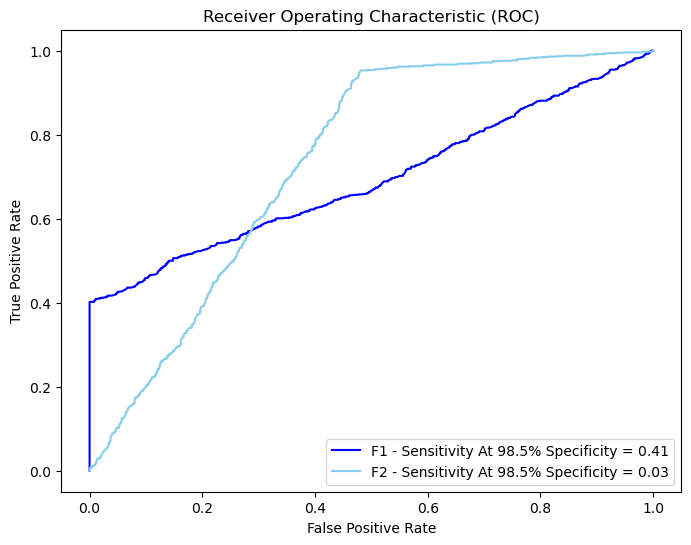

In [5]:
Xs = DF[['F1', 'F2','F3','F4']]
ys = DF['is_case']

# Calculate combined score using coefficients

# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 6))

# ROC curve for combine
fpr1, tpr1, _ = roc_curve(ys, DF['F1'])
roc_auc1 = roc_auc_score(ys, DF['F1'])
plt.plot(fpr1, tpr1, color='blue', label='F1 - Sensitivity At 98.5% Specificity = {:.2f}'.format(
    tpr1[np.argmin(1-fpr1>0.985)]))

# ROC curve for combine
fpr2, tpr2, _ = roc_curve(ys, DF['F2'])
roc_auc2 = roc_auc_score(ys, DF['F2'])
plt.plot(fpr2, tpr2, color='skyblue', label='F2 - Sensitivity At 98.5% Specificity = {:.2f}'.format(
    tpr2[np.argmin(1-fpr2>0.985)]))

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.savefig('Figure 1.png')
plt.show()


# Figure 2

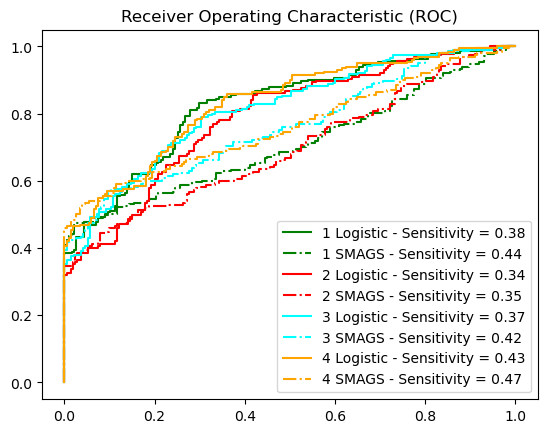

In [6]:
i=0
n_fold=4
Bs_train=[]
Ds_train=[]
colors=['blue','green','red','cyan','orange','magenta']
kfold = KFold(n_splits=n_fold, shuffle=True, random_state=randomstate)
Xs_train, Xs_test,ys_train, ys_test = train_test_split(Xs[['F1','F2']],ys,random_state=randomstate,test_size=0.2, shuffle=True)
for train, test in kfold.split(Xs_train):
    i=i+1
    log = LogisticRegression(random_state=randomstate).fit(Xs_train.loc[Xs_train.index[train]],ys_train.loc[ys_train.index[train]])
    Bs_train.append(np.append(log.coef_[0],log.intercept_))
    ys_probs1=log.predict_proba(Xs_train.loc[Xs_train.index[test]])
    fpr1, tpr1, _ = roc_curve(ys_train.loc[ys_train.index[test]], ys_probs1[:, 1])
    roc_auc1 = auc(fpr1,tpr1)   
    A=SMAGS(Xs_train.loc[Xs_train.index[train]],ys_train.loc[ys_train.index[train]],0.985)
    Ds_train.append(np.array(A[0:3]))
    fpr_smag, tpr_smag,_=roc_curve(ys_train.loc[ys_train.index[test]],
                                   np.matmul((Xs_train.loc[Xs_train.index[test]]).assign(I = 1),A[0:3] ))
    roc_auc_smag = auc(fpr_smag,tpr_smag)
    plt.plot(fpr1, tpr1,'-',color=colors[i], label= str(i) + ' Logistic - Sensitivity = %0.2f' % tpr1[np.argmin(1-fpr1>0.985)] )
    plt.plot(fpr_smag, tpr_smag,'-.',color=colors[i] ,label= str(i) + ' SMAGS - Sensitivity = %0.2f' % tpr_smag[np.argmin(1-fpr_smag>0.985)])
plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
plt.savefig('Figure 2.png')
plt.show()


# Figure 3

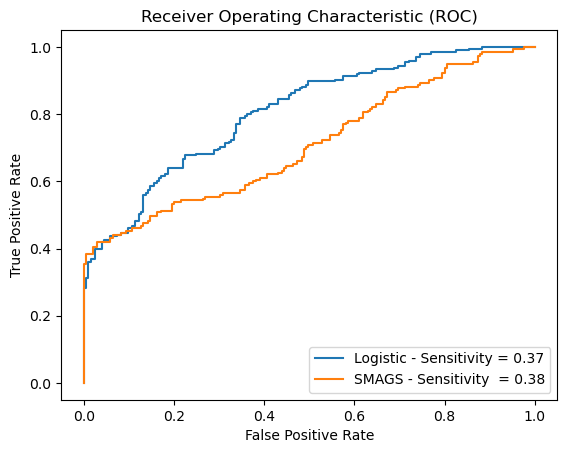

In [7]:
Av_Bs_test=np.array(Bs_train).mean(axis=0)
Av_Ds_test=np.array(Ds_train).mean(axis=0)

fprs_avg, tprs_avg, _ = roc_curve(ys_test, np.matmul((Xs_test).assign(I = 1),Av_Bs_test ))
roc_auc_avg = auc(fprs_avg,tprs_avg)

fprs_avg_smag, tprs_avg_smag,_=roc_curve(ys_test,np.matmul((Xs_test).assign(I = 1),Av_Ds_test ))
roc_auc_avg_smag = auc(fprs_avg_smag,tprs_avg_smag)


       
plt.plot(fprs_avg, tprs_avg, label=  'Logistic - Sensitivity = %0.2f' % tprs_avg[np.argmin((1-fprs_avg)>0.985)] )
plt.plot(fprs_avg_smag, tprs_avg_smag, label= 'SMAGS - Sensitivity  = %0.2f' % tprs_avg_smag[np.argmin((1-fprs_avg_smag)>0.985)])# +


plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('Figure 3.png')
plt.show()


# CancerSeek Data

In this section we are using the dataset provided by 
"Cohen, J. D., Li, L., Wang, Y., Thoburn, C., Afsari, B., Danilova, L., ... & Papadopoulos, N. (2018). Detection and localization of surgically resectable cancers with a multi-analyte blood test. Science, 359(6378), 926-930."

In [8]:
# Reading CancerSeek Data
S2=pd.read_excel('CRC_Analysis.xlsx',sheet_name='Sheet2')
S2.columns=S2.loc[1]
S3=pd.read_excel('CRC_Analysis.xlsx',sheet_name='Sheet3')

# Choosing Increasing Features from sheet 3
Main_Features=np.array(S3.loc[(S3.iloc[:,7]=='Increased')  & ((S3.iloc[1:,1])>0.6 )]['Unnamed: 0'])

#Preparing the final dataframe
df=(S2.loc[2:,np.append('Tumor type',Main_Features)])# 
df=df.dropna()

In [9]:
# Preparing Features and Labels 
X=df.iloc[:,1:]
X.iloc[27,1]=336427.986 # Charachter Values to Numeric
X.iloc[347,13]=608432.382 # Charachter Values to Numeric
y1=df.iloc[:,0]
X=X.astype(float)
y=pd.Series(np.where(y1=='Colorectum',1,0), index=y1.index)

# Figure 4 

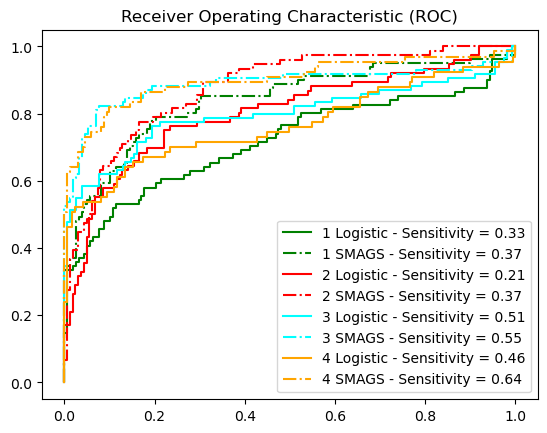

In [10]:
i=0
SP=0.985
n_fold=4
B_train=[]
D_train=[]
colors=['blue','green','red','cyan','orange','magenta']
kfold = KFold(n_splits=n_fold, shuffle=True, random_state=randomstate)
X_train, X_test,y_train, y_test = train_test_split(X,y,random_state=randomstate,test_size=0.2, shuffle=True)
for train, test in kfold.split(X_train):
    i=i+1
    log = LogisticRegression(random_state=randomstate).fit(X_train.loc[X_train.index[train]],y_train.loc[y_train.index[train]])
    B_train.append(np.append(log.coef_[0],log.intercept_))
    y_probs1=log.predict_proba(X_train.loc[X_train.index[test]])
    fpr1, tpr1, _ = roc_curve(y_train.loc[y_train.index[test]], y_probs1[:, 1])
    roc_auc1 = auc(fpr1,tpr1)
    
    A=SMAGS(X_train.loc[X_train.index[train]],y_train.loc[y_train.index[train]],SP)
    D_train.append(np.array(A[:X.shape[1]+1]))
    fpr_smags, tpr_smags,_=roc_curve(y_train.loc[y_train.index[test]],
                                     np.matmul((X_train.loc[X_train.index[test]]).assign(I = 1),A[:X.shape[1]+1] ))
    roc_auc_smags = auc(fpr_smags,tpr_smags)
    
    
    plt.plot(fpr1, tpr1,'-',color=colors[i], label = 
    str(i) + ' Logistic - Sensitivity = %0.2f' % tpr1[np.argmin(1-fpr1>SP)] )#+' AUC = %0.2f' % roc_auc1)
    plt.plot(fpr_smags, tpr_smags,'-.',color=colors[i] ,label= 
    str(i) + ' SMAGS - Sensitivity = %0.2f' % tpr_smags[np.argmin(1-fpr_smags>SP)])# +' AUC = %0.2f' % roc_auc_smag)


plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
plt.savefig('Figure 4.png')
plt.show()


# Figure 5

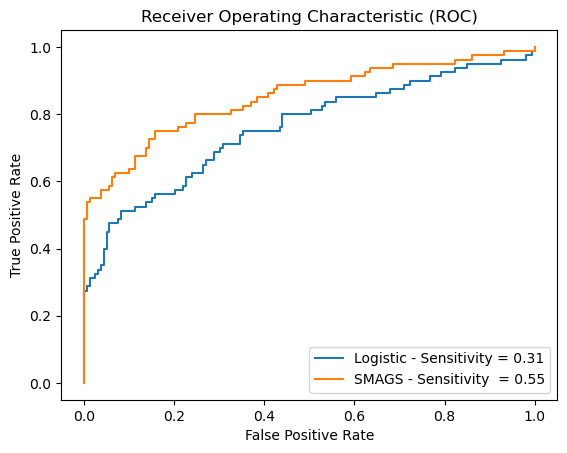

In [11]:
Av_B_test=np.array(B_train).mean(axis=0)
Av_D_test=np.array(D_train).mean(axis=0)

fpr_avg, tpr_avg, _ = roc_curve(y_test, np.matmul((X_test).assign(I = 1),Av_B_test ))
roc_auc_avg = auc(fpr_avg,tpr_avg)

fpr_avg_smag, tpr_avg_smag,_=roc_curve(y_test,np.matmul((X_test).assign(I = 1),Av_D_test ))
roc_auc_avg_smag = auc(fpr_avg_smag,tpr_avg_smag)


       
plt.plot(fpr_avg, tpr_avg, label=  'Logistic - Sensitivity = %0.2f' % tpr_avg[np.argmin((1-fpr_avg)>0.985)] )#+
plt.plot(fpr_avg_smag, tpr_avg_smag, label= 'SMAGS - Sensitivity  = %0.2f' % tpr_avg_smag[np.argmin((1-fpr_avg_smag)>0.985)])# +


plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('Figure 5.png')
plt.show()


# Feature Selection

In [12]:
n_selecting_features=8
ti=time()
selected_features=feature_selection(X_train,y_train,SP=0.985,num_features_to_keep=n_selecting_features)
print(' time ', np.round(time()-ti)) #New code

 time  2952.0


In [13]:
selected_features

['IL-6 (pg/ml)',
 'Prolactin (pg/ml)',
 'CEA (pg/ml)',
 'OPN (pg/ml)',
 'HGF (pg/ml)',
 'FGF2 (pg/ml)',
 'Myeloperoxidase (ng/ml)',
 'Follistatin (pg/ml)']

In [14]:
log_res = LogisticRegression(random_state=randomstate).fit(X_train.loc[:,selected_features],y_train)
log_coef_res=np.append(log_res.coef_[0],log_res.intercept_)
y_pred_res=np.array(log_res.predict_proba(X_test.loc[:,selected_features]))

# Figure 6

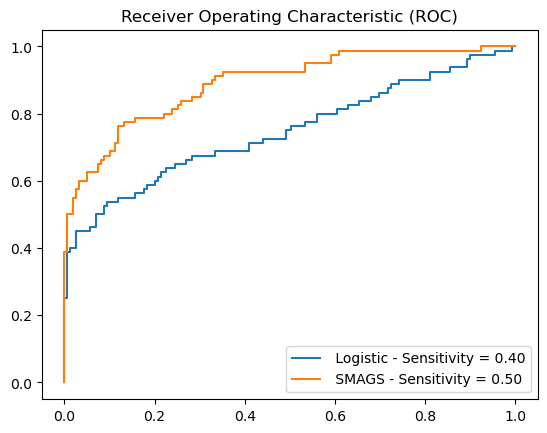

In [15]:
#Sensitivity and Specificity for Restricted Features Logistic Regression

fpr_log_res, tpr_log_res, _ = roc_curve(y_test,y_pred_res[:,1] )
roc_auc_log_res = auc(fpr_log_res,tpr_log_res)
plt.plot(fpr_log_res, tpr_log_res, label=  ' Logistic - Sensitivity = %0.2f' % tpr_log_res[np.argmin((1-fpr_log_res)>0.985)])


#Sensitivity and Specificity for Restricted Features SMAGS
smag_coef_res=SMAGS(X=X_train.loc[:,selected_features],y=y_train,SP=0.985)[0:(n_selecting_features+1)]
fpr_smag_res, tpr_smag_res,_=roc_curve(y_test,np.matmul((X_test.loc[:,selected_features]).assign(I = 1),
                                                      smag_coef_res ))
roc_auc_smag_res = auc(fpr_smag_res,tpr_smag_res)   
plt.plot(fpr_smag_res, tpr_smag_res, label= ' SMAGS - Sensitivity = %0.2f' % tpr_smag_res[np.argmin((1-fpr_smag_res)>0.985)])
plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
plt.savefig('Figure 6.png')
plt.show()


# LASSO

In [16]:
lasso = Lasso(alpha=0.00145,random_state=randomstate,normalize=True) 
lasso.fit((X_train), y_train)
y_pred_lasso = lasso.predict(X_test)

lasso_coefs=np.append(lasso.coef_,lasso.intercept_)
lasso_features=X.columns[lasso.coef_ != 0]
lasso_col_index=[i for i,j in enumerate(X.columns) if j in lasso_features]
len(lasso_features)

8

In [17]:
lasso_features

Index(['CEA (pg/ml)', 'FGF2 (pg/ml)', 'HGF (pg/ml)', 'Myeloperoxidase (ng/ml)',
       'OPN (pg/ml)', 'Prolactin (pg/ml)', 'SHBG (nM)', 'TIMP-1 (pg/ml)'],
      dtype='object', name=1)

 # Figure 7 

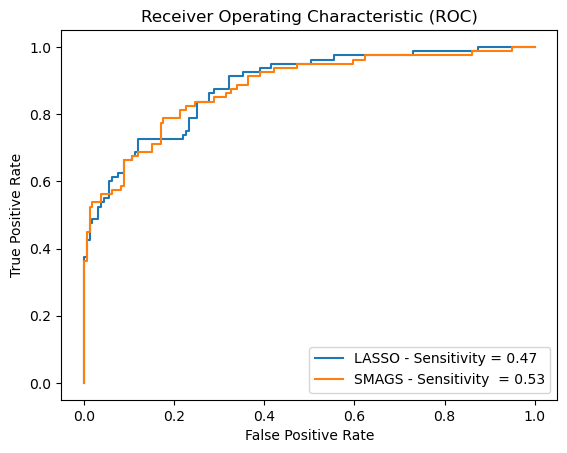

In [18]:
#Sensitivity and Specificity for LASSO

fpr_las, tpr_las, _ = roc_curve(y_test,y_pred_lasso)
roc_auc_avg = auc(fpr_las,tpr_las)
plt.plot(fpr_las, tpr_las, label=  'LASSO - Sensitivity = %0.2f' % tpr_las[np.argmin((1-fpr_las)>0.985)] )

#Sensitivity and Specificity for SMAGS
smag_vs_lass_coef=SMAGS(X=(X_train.iloc[:,lasso_col_index]),
                        y=y_train,SP=0.985)[0:(len(lasso_features)+1)]
fpr_smag_vs_lass, tpr_smag_vs_lass,_=roc_curve(y_test,np.matmul((
    (X_test.iloc[:,lasso_col_index])).assign(I = 1),smag_vs_lass_coef ))
roc_auc_smag_vs_lass = auc(fpr_smag_vs_lass,tpr_smag_vs_lass)
plt.plot(fpr_smag_vs_lass, tpr_smag_vs_lass, label= 'SMAGS - Sensitivity  = %0.2f' % 
         tpr_smag_vs_lass[np.argmin((1-fpr_smag_vs_lass)>0.985)])


plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('Figure 7.png')
plt.show()
